In [3]:
import yfinance as yf
import pandas as pd

# Download stock data
ticker = "ACGL"  # Replace with your desired ticker
data = yf.download(ticker, period="max")  # Download maximum historical data

# Fill NaN values with 0 (if any)
stock_data = data.fillna(0)

# Example usage
stock_data.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1995-09-14,2.277778,2.388889,2.277778,2.361111,2.361111,12915900
1995-09-15,2.333333,2.388889,2.305556,2.361111,2.361111,3802500
1995-09-18,2.333333,2.416667,2.333333,2.361111,2.361111,1345500
1995-09-19,2.333333,2.416667,2.333333,2.333333,2.333333,1305000
1995-09-20,2.333333,2.416667,2.333333,2.361111,2.361111,648900


In [2]:
!pip install pmdarima
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.1 MB/s eta 0:00:00


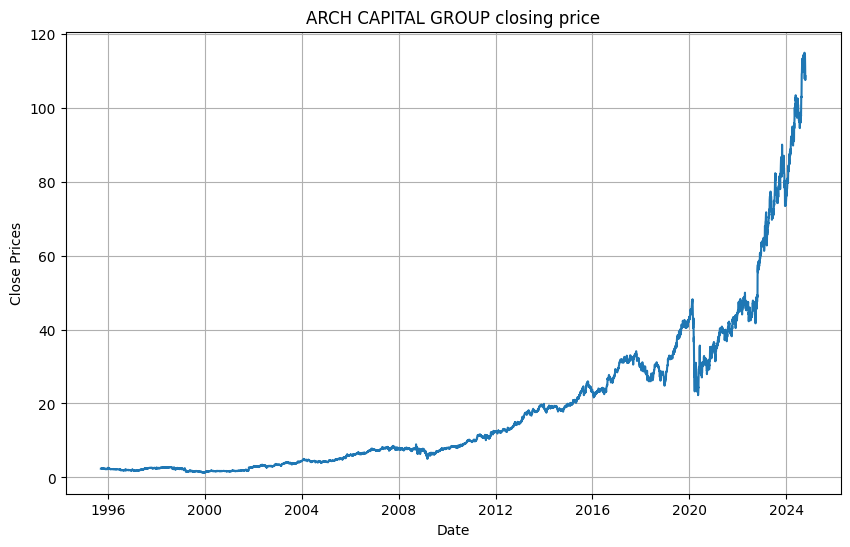

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

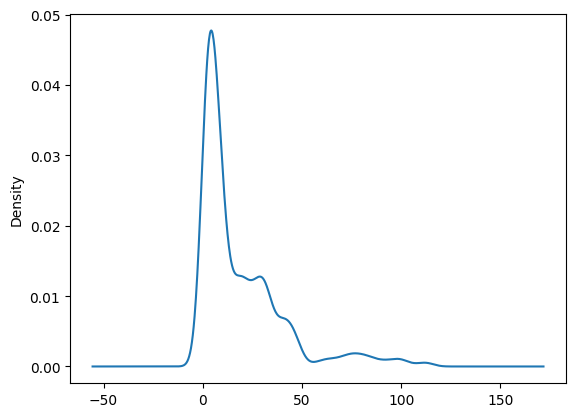

In [5]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

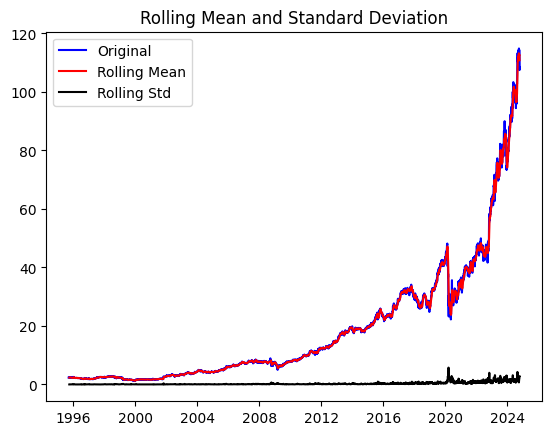

Results of dickey fuller test
Test Statistics                   5.039726
p-value                           1.000000
No. of lags used                 32.000000
Number of observations used    7292.000000
critical value (1%)              -3.431247
critical value (5%)              -2.861936
critical value (10%)             -2.566981
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Axes: ylabel='Density'>

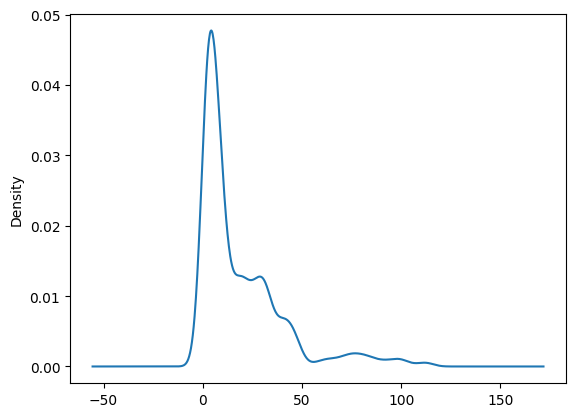

In [7]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

<Figure size 640x480 with 0 Axes>

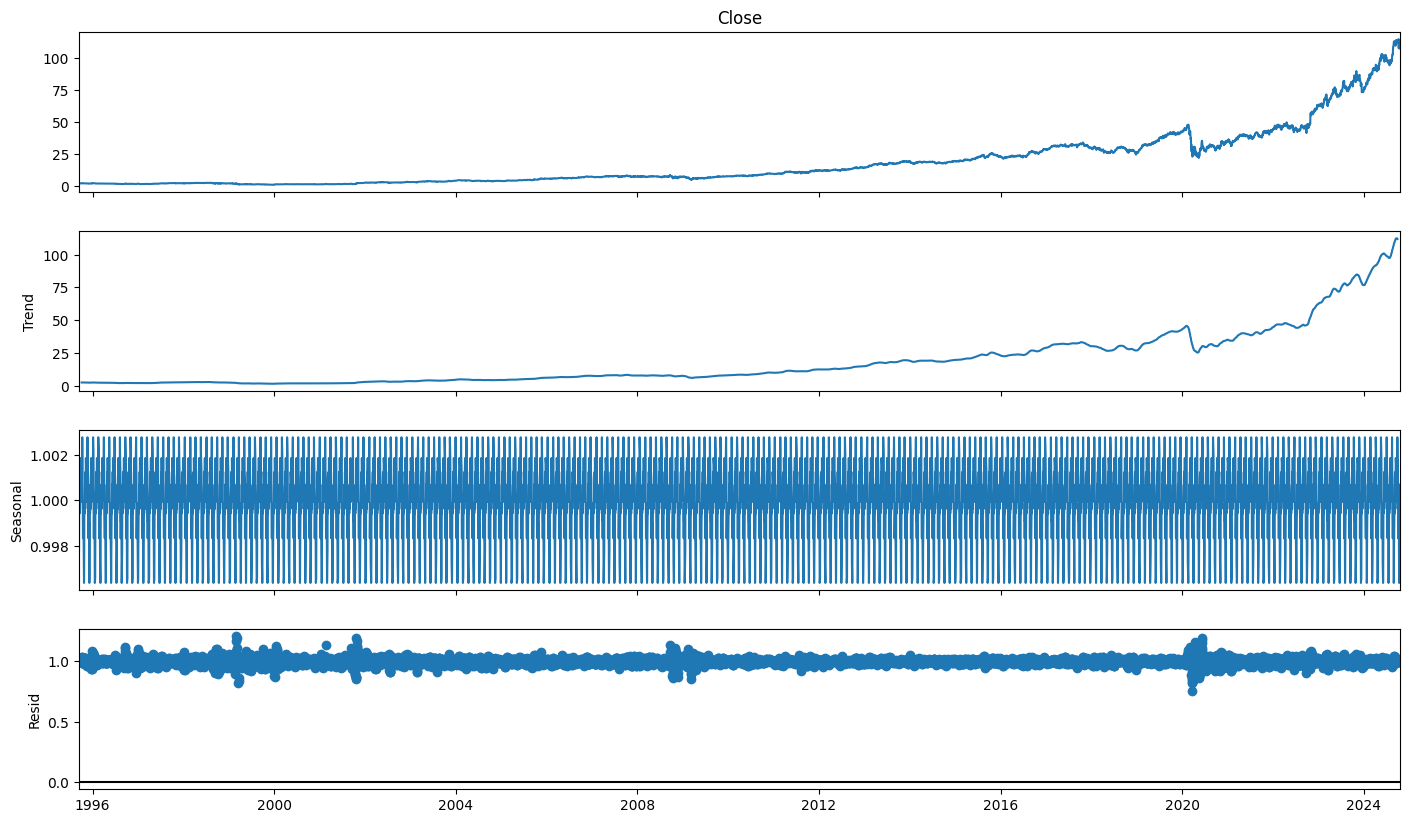

In [10]:
#To separate the trend and the seasonality from a time series,
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

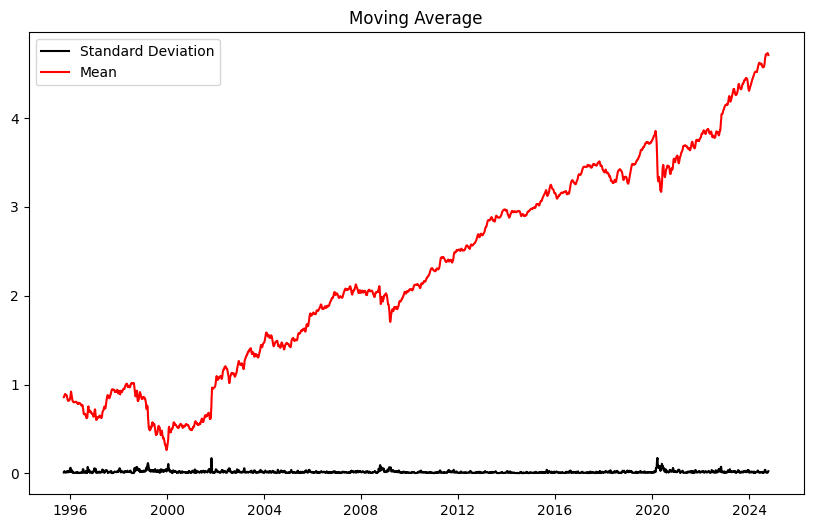

In [11]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

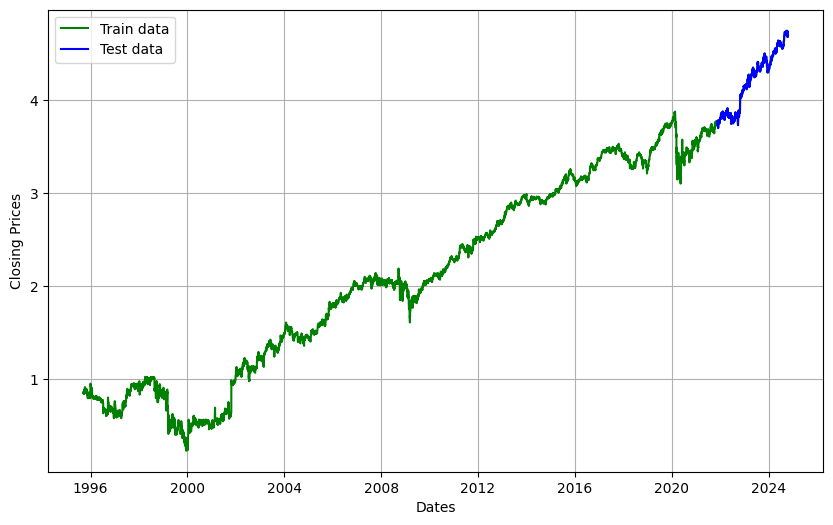

In [12]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-33899.453, Time=1.48 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-33980.335, Time=0.76 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-33982.998, Time=2.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-33897.725, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-33982.126, Time=2.60 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-33981.960, Time=2.61 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-33980.713, Time=5.03 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-33980.176, Time=0.54 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 15.466 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 6589
Model:               SARIMAX(0, 1, 1)   Log Likelihood               16994.499
Date:                Sat, 19 Oct 2024   AIC                         -33982.998
Time:              

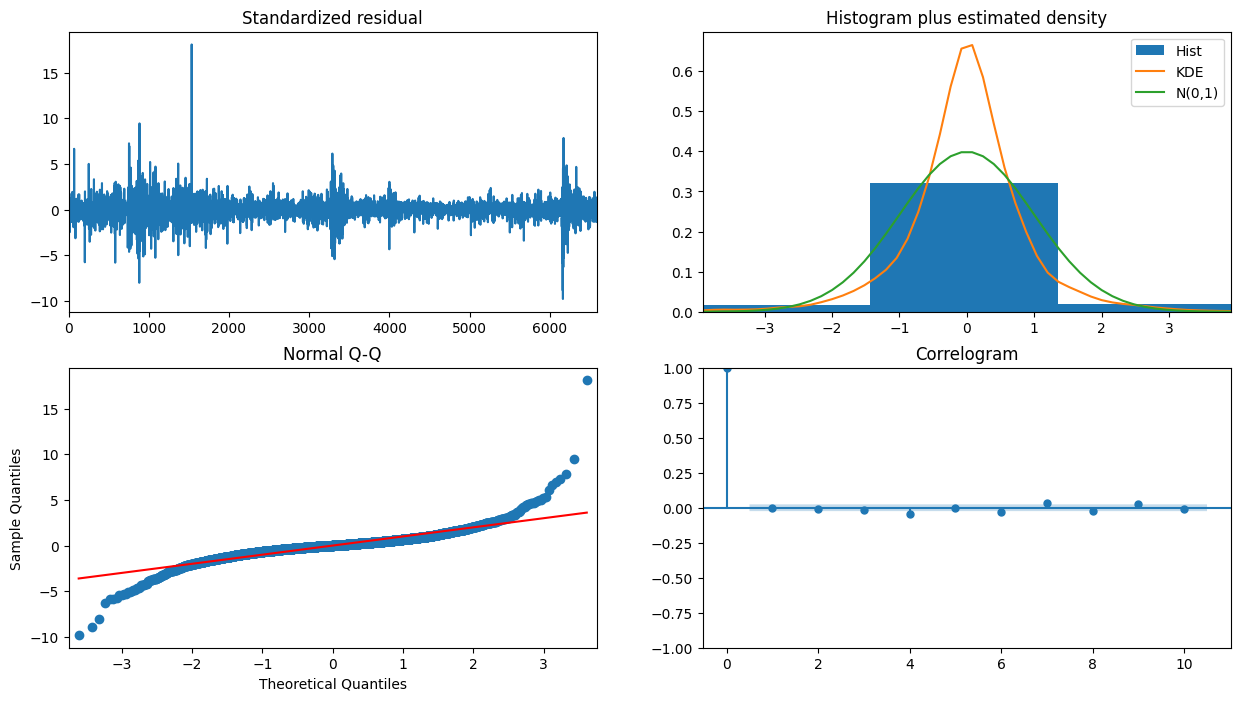

In [13]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [16]:
#As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()
print(fitted.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 6589
Model:                 ARIMA(1, 1, 2)   Log Likelihood               16992.793
Date:                Sat, 19 Oct 2024   AIC                         -33977.587
Time:                        07:06:51   BIC                         -33950.415
Sample:                             0   HQIC                        -33968.195
                               - 6589                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1591      0.513      0.310      0.756      -0.846       1.165
ma.L1         -0.2733      0.513     -0.533      0.594      -1.278       0.731
ma.L2          0.0076      0.061      0.126      0.9

In [23]:
# Forecast
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: too many values to unpack (expected 3)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


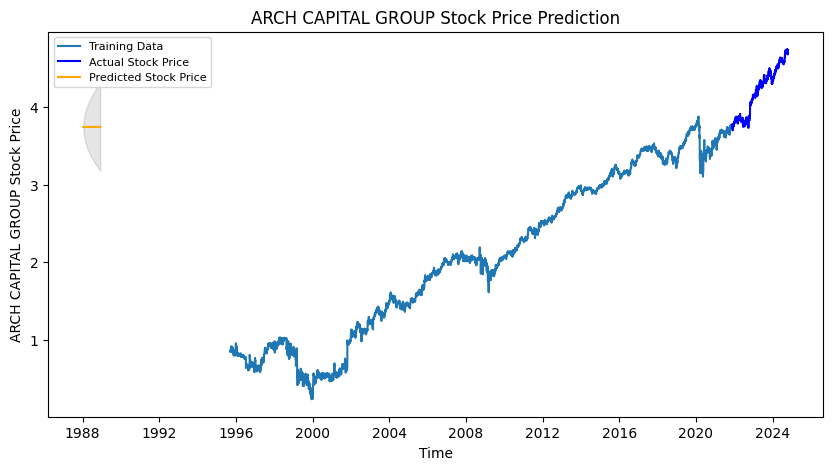

In [26]:
# Get forecast and confidence intervals
forecast_obj = fitted.get_forecast(steps=321)

# Extract forecasted values and confidence intervals
fc_series = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)

# Extract lower and upper confidence bounds
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series,
                 color='k', alpha=.10)
plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


In [25]:
# Run forecast and inspect the result
result = fitted.forecast(321, alpha=0.05)

# Print result to inspect how many values are being returned
print(type(result))
print(result)


<class 'pandas.core.series.Series'>
6589    3.742445
6590    3.742550
6591    3.742566
6592    3.742569
6593    3.742569
          ...   
6905    3.742569
6906    3.742569
6907    3.742569
6908    3.742569
6909    3.742569
Name: predicted_mean, Length: 321, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [27]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.3097861604690068
MAE: 0.4651495195905074
RMSE: 0.556584369587403
MAPE: nan


In [28]:
# Get forecast and confidence intervals
forecast_obj = fitted.get_forecast(steps=321)

# Extract forecasted values and confidence intervals
fc_series = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)

# Ensure the index of the forecast matches the test data
fc_series.index = test_data.index
conf_int.index = test_data.index

# Extract lower and upper confidence bounds
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')

# Correct confidence intervals plotting
plt.fill_between(fc_series.index, lower_series, upper_series,
                 color='k', alpha=.10)

plt.title('ARCH CAPITAL GROUP Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('ARCH CAPITAL GROUP Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


ValueError: Length mismatch: Expected axis has 321 elements, new values have 733 elements

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Figure size 1000x500 with 0 Axes>

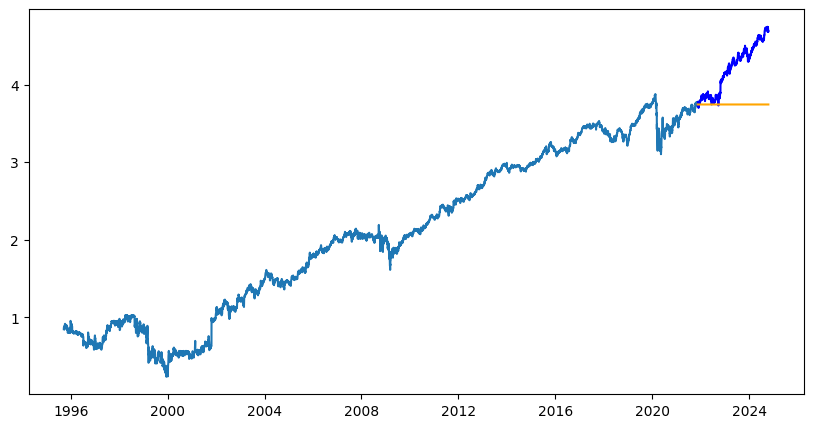

In [30]:
# Get forecast and confidence intervals
forecast_obj = fitted.get_forecast(steps=len(test_data))  # Use len(test_data) for steps

# Extract forecasted values and confidence intervals
fc_series = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)

# Ensure the index of the forecast matches the test data
fc_series.index = test_data.index  # Assign test_data's index to fc_series
conf_int.index = test_data.index   # Assign test_data's index to conf_int

# Extract lower and upper confidence bounds
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
# Get forecast and confidence intervals
forecast_obj = fitted.get_forecast(steps=len(test_data))  # Use len(test_data) for steps

# Extract forecasted values and confidence intervals
fc_series = forecast_obj.predicted_mean
conf_int = forecast_obj.conf_int(alpha=0.05)

# Ensure the index of the forecast matches the test data
fc_series.index = test_data.index  # Assign test_data's index to fc_series
conf_int.index = test_data.index   # Assign test_data's index to conf_int

# Extract lower and upper confidence bounds
lower_series = conf_int.iloc[:, 0]
upper_series = conf_int.iloc[:, 1]

# Plot
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted')

In [31]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.3097861604690068
MAE: 0.4651495195905074
RMSE: 0.556584369587403
MAPE: nan


In [32]:
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))

In [33]:
mape

nan

In [34]:
# report performance
mse = mean_squared_error(test_data, fc_series)  # Use fc_series for consistency
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc_series)  # Use fc_series for consistency
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc_series))  # Use fc_series for consistency
print('RMSE: '+str(rmse))

# Handle potential zero values in test_data
epsilon = 1e-10  # A small value to replace zeros
test_data_no_zeros = np.where(np.abs(test_data) < epsilon, epsilon, test_data)

# Calculate MAPE with zero handling
mape = np.mean(np.abs(fc_series - test_data_no_zeros) / np.abs(test_data_no_zeros))
print('MAPE: '+str(mape))

MSE: 0.3097861604690068
MAE: 0.4651495195905074
RMSE: 0.556584369587403
MAPE: 0.10578811822119201
